In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import torch.nn.functional as F

In [2]:
names = open("names.txt", "r").read().splitlines()
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [3]:
def build_dataset(names):
    block_size = 3 #context length of how many chars we take to predict the next char
    X, Y = [],[]
    
    for w in names:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # rolling window, makes sense when you run it
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [4]:

import random
random.seed(42)
random.shuffle(names)
X_train, Y_train = build_dataset(names[:int(0.8*len(names))]) #get first 80% of the dataset
X_valid, Y_valid = build_dataset(names[int(0.8*len(names)):int(0.9*len(names))]) # get between 80%-90%
X_test, Y_test = build_dataset(names[int(0.9*len(names)):]) # get last 10% of dataset

In [5]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

##### ======================================
#### We want our probabilities that get fed into softmax to be 100% uniform on the 1st run, that is because the lowest probability for each char should be 1/27. 
#### When we calculate the loss with logits and Y_train[x], we get loss=27, which should be ~3.29 according to our cross entropy loss calculation. So we want uniform logits, how do we do that? If all logits would be close to 0, they'd all roughly be equal, so let's try to not add bias (*0), and reduce our weights for the last layer (*0.01). Now, we start with loss=3.31 !!
-------------

#### Now, we also have a problem with our tanh function. Most values by far, take values very very close to -1 and 1. This means that the gradient for these activations is 0. Let's check below how often our h (activation) is in that flat region of tanh. Run below cell only after forward/backward cell which is below. In all white cells, the gradient would be squashed to 0, leading to dead potentially dead neurons (neurons that always have gradient 0 and thus never learn for all 32 examples)
#### To fix this, we obviously need to make sure that our activations (h) is not -1 or 1 or really close to those. We can also try to reduce the bias and weights in the first layer. Boom! No more white neurons that have 0 gradients. Setting weights and biases closer to 0 helped!
-------------

#### Now, let's not magically "weight" to 0 as it doesn't seem like a great idea. Let's do something more professional: set them to be Gaussian. This is called the Kaiming initialization, named after Kaiming He (author of "Delving Deep into Rectifiers"). The point here is to stop vanishing/exploding activations and gradients at the start of training. Kaiming init keeps the variance of inputs and outputs the same, even though activation functions like tanh would "squash" the outputs of the previous layer, thus reducing the variance. Whatever the outputs are from the last layer, in our tanh layer, every single input gets mapped to [-1,1], so we lose some variance. The way this keeps variance constant is by multiplying it by some "gain" and dividing it by the fan_in)=. The gain is there to account for how much variance we lose depending on which activation function we are using. Gain for ReLU = 2, because we lose 1/2 of variance because 1/2 of inputs get mapped to 0. For tanh, we use 5/3 for some reason (it still counters squashing of variance, so we are probably losing 3/5 of it). However, this does not help with activation and gradient explosions/vanishing during longer training. So we introduce batch normalization
-------------

#### Batch Norm normalizes the pre-activations to be roughly Gaussian. The normalization is done for each neuron, across all training examples in the batch. Since X.shape = (batchsize, #features) and W.shape = (#features, #neurons), we will end up with µ.shape = std.shape = (1,#neurons), which we will apply [element wise] to our pre-activations. However, strict optimization isn't always optimal for all data distributions or layers in the network, so we want to allow our network to undo the normalization if it thinks it's better. So, we introduce 2 more parameters, called Beta and Gamma. Since we applied our µ and std element wise (as they're (1,#neurons) vectors), we want to apply Beta and Gamma the same way, so they're both gonna be (1,#neurons). Beta is the shift, Gamma is the scaling, so Beta is initiliazed to 0, and Gamma initialized to 1. If we already have a learnable parameter that is a shift, we might as well get rid our bias term in this batch-normed layer.
-------------
#### We, however, face another problem now. First, we started by training our neural network example by example, then we introduced batches, where our examples were still separated and had nothing to do with each other, but now, with Batch Norm, all of our training examples are a function of each other, because we normalized them across examples. We can't simply feed in a single training example now, as our network is not used to it and hasn't optimized for it. To counter this, we can calculate a running mean and running std during our training, and on each iteration, update those "running" stats a little bit. It is a kind of a running average, so we need a small value alpha. The initialization is the same, but the update is running_µ(1-alpha) + current_µ(alpha), and same for std. Then, for test time and for inference, we will also normalize the data, but we will use the running mean and running std.

In [6]:
#plt.figure(figsize=(20,10))
#plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")
# activation for all 200 neurons, for the 32 batch examples.

In [7]:
print(-torch.tensor([1/27]).log())
n_hidden = 30
n_out = 27
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((n_hidden,200), generator=g) * (5/3 / (n_hidden**0.5))
                                            # each neuron here will get #features inputs. = emb.view(-1, emb_cols) = whatever,30
#b1 = torch.randn(200, generator=g) * 0.01
W2 = torch.randn((200,n_out), generator=g) * 0.01
b2 = torch.randn(n_out, generator=g) * 0

gamma = torch.ones((1, W1.shape[1]))
beta = torch.zeros((1, W1.shape[1]))

mean_running = torch.zeros((1, W1.shape[1]))
std_running = torch.ones((1, W1.shape[1]))

params = [C, W1, W2, b2, gamma, beta]

tensor([3.2958])


In [8]:
for p in params:
    p.requires_grad=True

In [9]:
lossi = []
stepi = []

In [10]:
eps = 1e-5
alpha = 1e-3
for i in range(100000):
    #forward pass
    ix = torch.randint(0,X_train.shape[0],(32,))
    emb = C[X_train[ix]]
    embinput = emb.view(-1,n_hidden)
    hpreact = embinput @ W1
    mean_i = hpreact.mean(dim=0,keepdims=True)
    std_i = hpreact.std(dim=0,keepdims=True) + eps
    hpreact = gamma*(hpreact - mean_i) / std_i + beta

    with torch.no_grad():
        mean_running = mean_running*(1-alpha) + mean_i*(alpha)
        std_running = std_running*(1-alpha) + std_i*(alpha)

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # output from our network
    loss = F.cross_entropy(logits, Y_train[ix])
    
        # backward pass
    # zero out all gradients
    for p in params:
        p.grad = None # same as setting to 0
    loss.backward()
    
    lr = 0.1 if i<80000 else 0.001 # decay
    for p in params:
        p.data += -lr*p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss)

tensor(2.1861, grad_fn=<NllLossBackward0>)


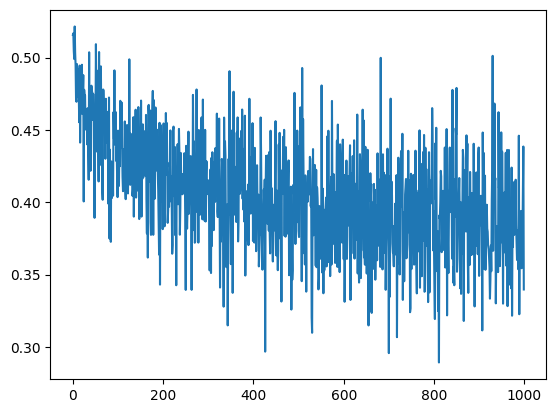

In [11]:
plt.plot(stepi, lossi)

In [12]:
# eval loss on full training data set after training
#------------

emb = C[X_train]
embinput = emb.view(-1,n_hidden)
hpreact = embinput @ W1
hpreact = gamma*((hpreact - mean_running) / (std_running + eps)) + beta
h = torch.tanh(hpreact)
logits = h @ W2 + b2 # output from our network
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(2.4742, grad_fn=<NllLossBackward0>)


In [13]:
# eval loss on full validation data set after training
#------------

emb = C[X_test]
embinput = emb.view(-1,n_hidden)
hpreact = embinput @ W1
hpreact = gamma*((hpreact - mean_running) / (std_running + eps)) + beta
h = torch.tanh(hpreact)
logits = h @ W2 + b2 # output from our network
loss = F.cross_entropy(logits, Y_test)
print(loss)

tensor(2.4703, grad_fn=<NllLossBackward0>)


In [14]:
# To end this off, let's sample from the model
#------------

block_size = 3
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # before it was (size of X, embedding vector dimension), but now we just need 1 example
        embinput = emb.view(-1,n_hidden)
        hpreact = embinput @ W1
        hpreact = gamma*((hpreact - mean_running) / (std_running + eps)) + beta
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1) # same as before, exponentiates, makes them sum to 1
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix] # sliding window again
        out.append(ix)
        if(ix == 0):
            break
    print(''.join(itos[i] for i in out))

chrpahxqtorhl.
khlimrri.
thve.
halanskejazhnel.
dmerric.
kaqhig.
hamararchaiiv.
janegy.
hhlm.
join.
qhinn.
shlin.
alian.
qhirathogdiaryxi.
janeelinsa.
med.
edoi.
tetlaley.
fryah.
asmina.
